In [2]:
import tensorflow as tf

print(f"tensorflow GPU version: {tf.__version__}")

tensorflow GPU version: 2.1.0


In [3]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
import datetime
# from autoencoder import Denoise
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
# from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
import cv2
import time
import string
import requests
import urllib.request

from utils import *

Using TensorFlow backend.


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:

# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note GENERATE_RES 4 or higher  
# will blow Google CoLab's memory and have not
# been tested extensivly.

GENERATE_RES = 2 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 128 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED = 54
SEED_SIZE = 100

# Configuration
DATA_PATH = 'Data/Dataset1000/'
EPOCHS = 50
BATCH_SIZE = 2
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 256px square images.


In [146]:
#Has to be multiple of 224
GENERATE_SQUARE = 224 * 4

print(GENERATE_SQUARE)

672


In [147]:
def train_augment_generator(train_image_gen, train_wm_gen, dir_path, shape, seed = 1, batch_size = 5):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''

    train_image_generator = train_image_gen.flow_from_directory(f'{dir_path}Original_Ims/', batch_size = batch_size, seed = seed, target_size=(shape, shape), shuffle=False)
    train_wm_generator = train_wm_gen.flow_from_directory(f'{dir_path}WM_Images/', batch_size = batch_size, seed = seed, target_size=(shape, shape), shuffle=False)

    while True:
        X1i = train_image_generator.next()
        X2i = train_wm_generator.next()
        #One hot encoding RGB images
        # wm_encoded = X2i
        # np_wm = np.asarray(wm_encoded)

        yield tf.cast(X2i[0],tf.float32), tf.cast(X1i[0], tf.float32)

In [148]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
msk_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_augment_generator(train_datagen, msk_datagen, "Data/Dataset1000/Train/", GENERATE_SQUARE, batch_size=BATCH_SIZE)
valid_generator = train_augment_generator(train_datagen, msk_datagen, "Data/Dataset1000/Train/", GENERATE_SQUARE, batch_size=BATCH_SIZE)
test_generator = train_augment_generator(train_datagen, msk_datagen, "Data/Dataset1000/Train/", GENERATE_SQUARE, batch_size=BATCH_SIZE)

throw_away_gen = train_datagen.flow_from_directory(
    directory="Data/Dataset1000/Train/WM_Images/",
    target_size=(GENERATE_SQUARE, GENERATE_SQUARE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="input",
    shuffle=True,
    seed=SEED)

test_away_gen = train_datagen.flow_from_directory(
    directory="Data/Dataset1000/Test/WM_Images/",
    target_size=(GENERATE_SQUARE, GENERATE_SQUARE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="input",
    shuffle=True)

unseen_test_away_gen = train_datagen.flow_from_directory(
    directory="Data/Dataset1000/UnseenTest/",
    target_size=(GENERATE_SQUARE, GENERATE_SQUARE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="input",
    shuffle=True)

Found 12000 images belonging to 1 classes.
Found 751 images belonging to 1 classes.
Found 29 images belonging to 1 classes.


Found 12000 images belonging to 1 classes.
Found 12000 images belonging to 1 classes.


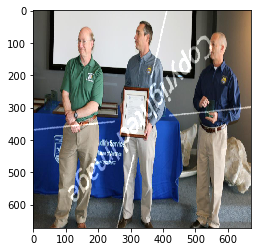

In [149]:
data_list = []
batch_index = 0

data = next(train_generator)

plt.imshow(data[0][0])

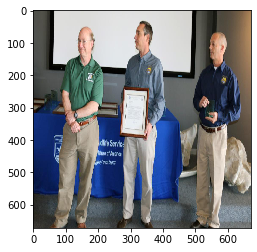

In [150]:
plt.imshow(data[1][0])

In [151]:
STEP_SIZE_TRAIN=throw_away_gen.n//BATCH_SIZE
STEP_SIZE_VALID=throw_away_gen.n//BATCH_SIZE

print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)
print(BATCH_SIZE)

6000 6000
2


In [152]:
def build_discriminator(image_shape, base_number_of_filters, leak = 0.2, channels = 3, kernel_size = (3,3), strides = (2,2) ):
    
    # f = config.base_number_of_filters
    # k = config.kernel_size
    # s = config.strides
    # sz = config.train_size
    # c = config.channels

    model = Sequential([
      layers.Input(shape=(image_shape, image_shape, channels)),
      layers.Conv2D(base_number_of_filters, kernel_size, strides, padding="same", name="dconv0"),
      layers.LeakyReLU(leak, name="dact0"),

      layers.Conv2D(2*base_number_of_filters, kernel_size, strides, padding="same", name="dconv1"),
      layers.BatchNormalization(name="dbn1"),
      layers.LeakyReLU(leak, name="dact1"),

      layers.Conv2D(4*base_number_of_filters, kernel_size, strides, padding="same", name="dconv2"),
      layers.BatchNormalization(name="dbn2"),
      layers.LeakyReLU(leak, name="dact2"),

      Conv2D(8*base_number_of_filters, kernel_size, strides, padding="same", name="dconv3"),
      layers.BatchNormalization(name="dbn3"),
      layers.LeakyReLU(leak, name="dact3"),

      layers.Flatten(name="dflatout"),
      layers.Dense(1, name="ddenseout")])
    

    return model

class Denoise(Model):
  def __init__(self, in_shp):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(in_shp, in_shp, 3)),
      layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),      
      ])

    self.decoder = tf.keras.Sequential([

      layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(256, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same')
      ])
    
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

class Denoise_Bigger(Model):
  def __init__(self, in_shp):
    super(Denoise_Bigger, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(in_shp, in_shp, 3)),
      layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)
      ])

    self.decoder = tf.keras.Sequential([

      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(256, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same')
      ])
    
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [153]:
def generator_d_loss(generated_output):
    # [1,1,...,1] with generated images since we want the discriminator to judge them as real
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)


def generator_abs_loss(labels, generated_images, lmdb):
    # As well as "fooling" the discriminator, we want particular pressure on ground-truth accuracy
    return lmdb * tf.losses.absolute_difference(labels, generated_images)  # mean

In [154]:
def discriminator_objective(d_x, g_z, smoothing_factor = 0.9):
    """
    d_x = real output
    g_z = fake output
    """
    real_loss = cross_entropy(tf.ones_like(d_x) * smoothing_factor, d_x) # If we feed the discriminator with real images, we assume they all are the right pictures --> Because of that label == 1
    fake_loss = cross_entropy(tf.zeros_like(g_z), g_z) # Each noise we feed in are fakes image --> Because of that labels are 0
    
    total_loss = real_loss + fake_loss
    
    return total_loss

In [155]:
def root_mean_squared_error(y_true, y_pred):
        return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true))) 

def get_random_string(length):
    letters = string.ascii_lowercase
    result_str = ''.join(rnd.choice(letters) for i in range(length))
    return result_str

In [156]:
print(GENERATE_SQUARE)
autoencoder = Denoise(GENERATE_SQUARE)
autoencoder.compile(optimizer='adam', loss=root_mean_squared_error)
weight_path = "Weights/20200915-225635/_pretrained_weights0005.h5"


time_stamp = time.strftime("%Y%m%d-%H%M%S")
checkpoint_dir = f'Weights\\{time_stamp}\\'
os.makedirs(checkpoint_dir, exist_ok=True)
mc = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir + '_pretrained_weights{epoch:04d}.h5', save_weights_only=True, save_freq=1)

672


In [141]:
#################################BIGGER VERSION#############################
print(GENERATE_SQUARE)
autoencoder = Denoise_Bigger(GENERATE_SQUARE)
autoencoder.compile(optimizer='nadam', loss=root_mean_squared_error)
weight_path = "Weights_Bigger/20200928-002356/_pretrained_weights0034.h5"


time_stamp = time.strftime("%Y%m%d-%H%M%S")
checkpoint_dir = f'Weights_Bigger\\{time_stamp}\\'
os.makedirs(checkpoint_dir, exist_ok=True)
mc = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir + '_pretrained_weights{epoch:04d}.h5', save_weights_only=True, save_freq=1)

1568


In [157]:
autoencoder.build((1,GENERATE_SQUARE,GENERATE_SQUARE,3))
autoencoder.load_weights(weight_path)

In [ ]:

autoencoder.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20000,
                    callbacks=[mc])

In [95]:
autoencoder.build((1,GENERATE_SQUARE,GENERATE_SQUARE,3))
# autoencoder.load_weights(weight_path)
autoencoder.load_weights(weight_path)

# **Copyrightous Disapearus**

(1, 672, 672, 3)
(1, 672, 672, 3)


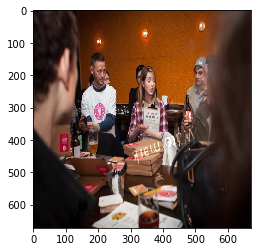

In [214]:
data_list = []
batch_index = 0

data = test_away_gen.next()
data_list.append(data[1][:-BATCH_SIZE+1])
batch_index = batch_index + 1
print(np.array(data_list[0]).shape)

predicted = autoencoder.predict(data_list[0])
predicted_twice = autoencoder.predict(predicted)
predicted_thrice = autoencoder.predict(predicted_twice)

# print(predicted)
print(predicted.shape)
plt.imshow(data[1][0])

# cv2.imshow('image',predicted[0]*255)

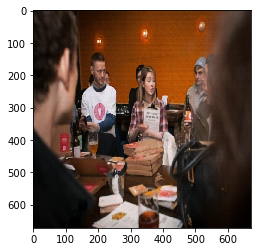

In [215]:
plt.imshow(predicted[0])

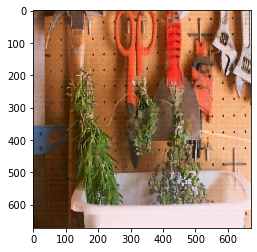

In [200]:
plt.imshow(predicted_twice[0])

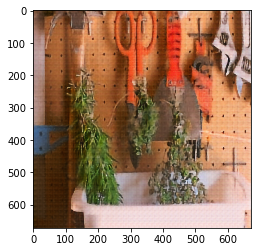

In [201]:
plt.imshow(predicted_thrice[0])

 <img src="Assets/Pipeline.png" />

In [ ]:
rnd_string = get_random_string(10)
print(rnd_string)
cv2.imwrite(f"Output/im_{rnd_string}_original.png", cv2.cvtColor(data[1][0]*255., cv2.COLOR_RGB2BGR))
cv2.imwrite(f"Output/im_{rnd_string}_1.png", cv2.cvtColor( predicted[0]*255., cv2.COLOR_RGB2BGR))
cv2.imwrite(f"Output/im_{rnd_string}_2.png", cv2.cvtColor( predicted_twice[0]*255., cv2.COLOR_RGB2BGR))
cv2.imwrite(f"Output/im_{rnd_string}_3.png", cv2.cvtColor( predicted_thrice[0]*255., cv2.COLOR_RGB2BGR))

In [ ]:
r = requests.post(
    "https://api.deepai.org/api/torch-srgan",
    files={
        'image': open('Output/im_thvhtyvdzm_1.png', 'rb'),
    },
    headers={'api-key': 'quickstart-QUdJIGlzIGNvbWluZy4uLi4K'}
)
API_out = r.json()

In [ ]:
from PIL import Image

img = Image.open('data/input/test_images/sample_image.jpg')
lr_img = np.array(img)

In [ ]:
from ISR.models import RDN

rdn = RDN(weights='psnr-small')
sr_img = rdn.predict(lr_img)
Image.fromarray(sr_img)